--------------------------------
--------------------------------

# OLA - Ensemble Learning
--------------------------------
--------------------------------

## Defining Problem Statement & Exploratory Data Analysis

### Problem Statement:

Recruiting and retaining drivers is seen by industry watchers as a tough battle for Ola. Churn among drivers is high and it’s very easy for drivers to stop working for the service on the fly or jump to Uber depending on the rates.
As the companies get bigger, the high churn could become a bigger problem. To find new drivers, Ola is casting a wide net, including people who don’t have cars for jobs. But this acquisition is really costly. Losing drivers frequently impacts the morale of the organization and acquiring new drivers is more expensive than retaining existing ones.
You are working as a data scientist with the Analytics Department of Ola, focused on driver team attrition. You are provided with the monthly information for a segment of drivers for 2019 and 2020 and tasked to predict whether a driver will be leaving the company or not based on their attributes like
•	Demographics (city, age, gender etc.)
•	Tenure information (joining date, Last Date)
•	Historical data regarding the performance of the driver (Quarterly rating, Monthly business acquired, grade, Income)


### Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = 'darkgrid')
import datetime as dt

import warnings # supress warnings
warnings.filterwarnings('ignore')

### Importing Data & removing non-relevant columns / duplicates

In [2]:
#importing data 
raw_data = pd.read_csv('ola_driver_scaler.csv')

In [3]:
#creating copy of imported data and removing spaces from column names
data = raw_data.copy(deep = True)
data.columns = data.columns.str.strip()
data.columns = data.columns.str.replace(' ', '_')
data.columns = data.columns.str.replace('-', '_')
data.sample(100).head()

,Unnamed:_0,MMM_YY,Driver_ID,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining_Designation,Grade,Total_Business_Value,Quarterly_Rating
19051,19051,05/01/19,2782,26.0,0.0,C19,1,29582,16/05/19,NaN,1,1,0,1
18869,18869,01/01/20,2753,39.0,1.0,C11,1,144726,07/08/13,NaN,1,5,3819530,3
12427,12427,02/01/20,1852,55.0,0.0,C3,1,69118,15/06/18,NaN,1,2,288840,4
270,270,01/01/19,50,49.0,1.0,C5,0,89367,20/11/18,NaN,3,3,110310,1
7147,7147,06/01/19,1069,36.0,1.0,C6,0,55834,12/10/18,NaN,2,2,0,2


In [4]:
#data preprocessing

#dropping non-relevant columns
data.drop(columns = ['Unnamed:_0'],axis = 1, inplace = True)

#converting columns to datetime format
data['MMM_YY'] = pd.to_datetime(data['MMM_YY'], format='%m/%d/%y')
data['Dateofjoining'] = pd.to_datetime(data['Dateofjoining'], format='%d/%m/%y')
data['LastWorkingDate'] = pd.to_datetime(data['LastWorkingDate'], format='%d/%m/%y')

#sorting values 
data.sort_values(by = ['Driver_ID', 'MMM_YY'], ascending = [True, True], na_position = 'first', inplace=True)

In [5]:
print('-'*80)
print('Range of MMM_YY')
print(f'Min : {data.MMM_YY.min()} \t Max : {data.MMM_YY.max()}')
print(data['MMM_YY'].max() - data['MMM_YY'].min())
print('-'*80)

print('Range of LastWorkingDate')
print(f'Min : {data.LastWorkingDate.min()} \t Max : {data.LastWorkingDate.max()}')
print(data['LastWorkingDate'].max() - data['LastWorkingDate'].min())
print('-'*80)


print('Range of Dateofjoining')
print(f'Min : {data.Dateofjoining.min()} \t Max : {data.Dateofjoining.max()}')
print(data['Dateofjoining'].max() - data['Dateofjoining'].min())
print('-'*80)

--------------------------------------------------------------------------------
Range of MMM_YY
Min : 2019-01-01 00:00:00 	 Max : 2020-12-01 00:00:00
700 days 00:00:00
--------------------------------------------------------------------------------
Range of LastWorkingDate
Min : 2018-12-31 00:00:00 	 Max : 2020-12-28 00:00:00
728 days 00:00:00
--------------------------------------------------------------------------------
Range of Dateofjoining
Min : 2013-01-04 00:00:00 	 Max : 2020-12-28 00:00:00
2915 days 00:00:00
--------------------------------------------------------------------------------


In [6]:
#Correcting values in column 'LastWorkingDate' '03-11-2019' <--> '11-03-2019' 
def LastWorkingDate(row):
    if pd.isnull(row.LastWorkingDate) or (row.LastWorkingDate.month == row.MMM_YY.month): 
        return row.LastWorkingDate
    elif (row.LastWorkingDate.day == row.MMM_YY.month):
        return dt.datetime(row.LastWorkingDate.year, row.LastWorkingDate.day, row.LastWorkingDate.month)
    else: return row.LastWorkingDate

data['LastWorkingDate'] = data[['MMM_YY', 'LastWorkingDate']].apply(LastWorkingDate, axis = 1)

In [7]:
#Correcting values in column 'Dateofjoining' '03-11-2019' <--> '11-03-2019' 
def Dateofjoining(row):
    if row.LastWorkingDate < row.Dateofjoining: 
        return dt.datetime(row.Dateofjoining.year, row.Dateofjoining.day, row.Dateofjoining.month)
    else: return row.Dateofjoining
    
data.Dateofjoining = data[['LastWorkingDate', 'Dateofjoining']].apply(Dateofjoining, axis = 1)

In [8]:
data.head()

,MMM_YY,Driver_ID,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining_Designation,Grade,Total_Business_Value,Quarterly_Rating
0,2019-01-01,1,28.0,0.0,C23,2,57387,2018-12-24,NaT,1,1,2381060,2
1,2019-02-01,1,28.0,0.0,C23,2,57387,2018-12-24,NaT,1,1,-665480,2
2,2019-03-01,1,28.0,0.0,C23,2,57387,2018-12-24,2019-03-11,1,1,0,2
3,2020-11-01,2,31.0,0.0,C7,2,67016,2020-06-11,NaT,2,2,0,1
4,2020-12-01,2,31.0,0.0,C7,2,67016,2020-06-11,NaT,2,2,0,1


### Creating condensed dataframe i.e. one-row per Driver_ID

In [9]:
#creating condensed dataframe i.e. one-row per Driver_ID
df = data.pivot_table(index= ['Driver_ID', 'City', 'Education_Level'],
                      values=['MMM_YY', 'Age','Gender', 'Income', 'Dateofjoining', 'LastWorkingDate','Joining_Designation',
                             'Grade', 'Total_Business_Value'], 
                      aggfunc={'MMM_YY':'last', 'Age':'max', 'Gender':'max', 'Income':'mean', 'Dateofjoining':'min', 
                               'LastWorkingDate': 'max', 'Joining_Designation': 'min', 'Grade':'max', 
                               'Total_Business_Value':'sum'})

df.reset_index(inplace= True)

In [10]:
#Create a column which tells whether the quarterly rating has decreased for that driver 
#for those whose quarterly rating has decreased we assign the value 1 else 0

qtr_rating = data[[ 'Driver_ID', 'Quarterly_Rating', 'MMM_YY']]
qtr_rating['year_qtr'] = pd.PeriodIndex(data['MMM_YY'], freq='Q')
qtr_rating = qtr_rating.sort_values(by = ['Driver_ID', 'year_qtr'], ascending = [True, False]) 


df_temp = qtr_rating.pivot_table(index= ['Driver_ID','year_qtr' ],
                      values=['Quarterly_Rating'],
                      aggfunc={'Quarterly_Rating':'mean'}, sort = True)
df_temp.reset_index(inplace= True)
df_temp['previous_qtr_rating'] = df_temp.groupby(['Driver_ID'])['Quarterly_Rating'].shift(1)


df_qtr_rating = df_temp.pivot_table(index= ['Driver_ID'],
                      values=['year_qtr','Quarterly_Rating', 'previous_qtr_rating'],
                      aggfunc='last', sort = True)
df_qtr_rating.reset_index(inplace= True)


def decrease_qtr_rating(row):
    if row['Quarterly_Rating'] < row['previous_qtr_rating']: return 1
    else: return 0

df_qtr_rating['decrease_qtr_rating'] = df_qtr_rating.apply(decrease_qtr_rating, axis = 1)

#merging qtr_rating columns to condensed dataframe
df = df.merge(df_qtr_rating[['Driver_ID','Quarterly_Rating','previous_qtr_rating','decrease_qtr_rating']], 
              how='left', on='Driver_ID')

#filling values where 'previous_qtr_rating' is NA
df['previous_qtr_rating'].fillna(df['Quarterly_Rating'], inplace = True)


In [11]:
#Create a column which tells whether the monthly income has increased for that driver 
#for those whose monthly income has increased we assign the value 1

monthly_income = data[[ 'Driver_ID', 'Income', 'MMM_YY']]
monthly_income = monthly_income.sort_values(by = ['Driver_ID', 'MMM_YY'], ascending = [True, True])


monthly_income['previous_month_income'] = monthly_income.groupby(['Driver_ID'])['Income'].shift(1)

def decrease_month_income(row):
    if row['Income'] < row['previous_month_income']: return 1
    else: return 0

monthly_income['decrease_month_income'] = monthly_income.apply(decrease_month_income, axis = 1)

monthly_income[monthly_income['decrease_month_income'] == 1]

#Since only one case was found where Drivers current month's income was less than previous month Income.
#We will not be including this feature in main dataframe

,Driver_ID,Income,MMM_YY,previous_month_income,decrease_month_income
4012,582,47682,2020-12-01,52450.0,1


=> **Since only one case was found where Drivers current month's income was less than previous month Income.
We will not be merging this feature in main dataframe**

In [12]:
#creating column "days_of_exp" (experience) based on joining date & last working date
def exp(row):
    if row['LastWorkingDate'] < row['Dateofjoining']: return np.nan
    elif pd.isnull(row['LastWorkingDate']): return (dt.datetime(2020, 12, 1) - row['Dateofjoining']).days
    else: return (row['LastWorkingDate'] - row['Dateofjoining']).days

df['days_of_exp'] = df.apply(exp, axis =1) 

<AxesSubplot:>

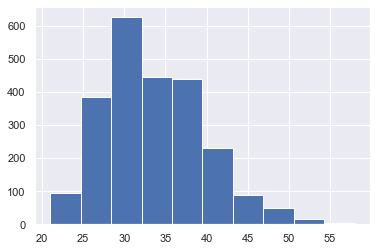

In [13]:
df.Age.hist()

In [14]:
#Creating categorical variable for Age
df['age_bin'] = pd.cut(x=df['Age'], bins=range(15,60,5))
print(df['age_bin'].dtype)
df['age_bin'].value_counts().sort_index()

category


(15, 20]      0
(20, 25]    174
(25, 30]    590
(30, 35]    789
(35, 40]    501
(40, 45]    231
(45, 50]     76
(50, 55]     19
Name: age_bin, dtype: int64

<AxesSubplot:>

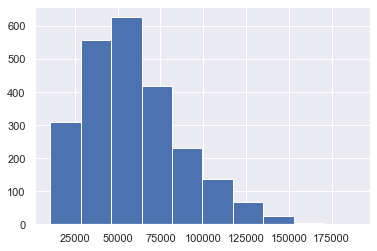

In [15]:
df.Income.hist()

In [16]:
#Creating categorical variable for Income
df['income_bin'] = pd.cut(x=df['Income'], bins=range(0,200000,25000))
print(df['income_bin'].dtype)
df['income_bin'].value_counts().sort_index()

category


(0, 25000]          229
(25000, 50000]      766
(50000, 75000]      775
(75000, 100000]     381
(100000, 125000]    161
(125000, 150000]     62
(150000, 175000]      6
Name: income_bin, dtype: int64

<AxesSubplot:>

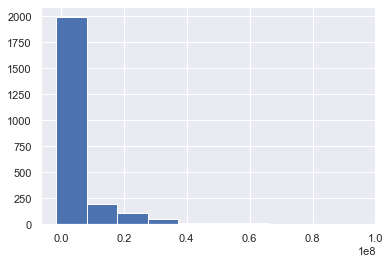

In [17]:
df.Total_Business_Value.hist()

<AxesSubplot:>

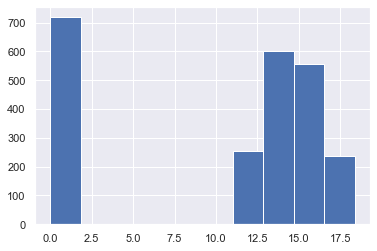

In [18]:
np.log(df.Total_Business_Value + 1).hist(bins = 10)

In [19]:
#Creating categorical variable for Total_Business_Value
df['total_business_value_bin'] = pd.cut(x=np.log(df.Total_Business_Value + 1), bins= [-0.1,10,15,20])
print(df['total_business_value_bin'].dtype)
df['total_business_value_bin'].value_counts().sort_index()


category


(-0.1, 10.0]    720
(10.0, 15.0]    980
(15.0, 20.0]    671
Name: total_business_value_bin, dtype: int64

In [20]:
#Target variable creation: driver whose last working day is present will have the value 1
def target_creation(row):
    if pd.isnull(row): return 0
    else: return 1

df['target'] = df['LastWorkingDate'].apply(target_creation)

In [21]:
df.set_index('Driver_ID', inplace=True)
df.to_csv('condensed_data')

In [22]:
df.head()

,City,Education_Level,Age,Dateofjoining,Gender,Grade,Income,Joining_Designation,LastWorkingDate,MMM_YY,Total_Business_Value,Quarterly_Rating,previous_qtr_rating,decrease_qtr_rating,days_of_exp,age_bin,income_bin,total_business_value_bin,target
Driver_ID,,,,,,,,,,,,,,,,,,,
1,C23,2,28.0,2018-12-24,0.0,1,57387.0,1,2019-03-11,2019-03-01,1715580,2.0,2.0,0,77,"(25, 30]","(50000, 75000]","(10.0, 15.0]",1
2,C7,2,31.0,2020-06-11,0.0,2,67016.0,2,NaT,2020-12-01,0,1.0,1.0,0,173,"(30, 35]","(50000, 75000]","(-0.1, 10.0]",0
4,C13,2,43.0,2019-07-12,0.0,2,65603.0,2,2020-04-27,2020-04-01,350000,1.0,1.0,0,290,"(40, 45]","(50000, 75000]","(10.0, 15.0]",1
5,C9,0,29.0,2019-01-09,0.0,1,46368.0,1,2019-03-07,2019-03-01,120360,1.0,1.0,0,57,"(25, 30]","(25000, 50000]","(10.0, 15.0]",1
6,C11,1,31.0,2020-07-31,1.0,3,78728.0,3,NaT,2020-12-01,1265000,2.0,1.0,0,123,"(30, 35]","(75000, 100000]","(10.0, 15.0]",0


In [23]:
df.describe(include = np.number, percentiles=[.25,.5,.75,.90,.95, .99, .999]).round(2).T

,count,mean,std,min,25%,50%,75%,90%,95%,99%,99.9%,max
Education_Level,2381.0,1.01,0.82,0.0,0.0,1.0,2.0,2.0,2.0,2.0,2.00,2.0
Age,2381.0,33.66,5.98,21.0,29.0,33.0,37.0,42.0,45.0,50.0,54.62,58.0
Gender,2381.0,0.41,0.49,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.00,1.0
Grade,2381.0,2.10,0.94,1.0,1.0,2.0,3.0,3.0,4.0,4.2,5.00,5.0
Income,2381.0,59232.46,28298.21,10747.0,39104.0,55285.0,75835.0,99300.0,113807.0,136984.4,163717.08,188418.0
Joining_Designation,2381.0,1.82,0.84,1.0,1.0,2.0,2.0,3.0,3.0,4.0,5.00,5.0
Total_Business_Value,2381.0,4586741.82,9127115.31,-1385530.0,0.0,817680.0,4173650.0,14970770.0,23471030.0,43135092.0,64540291.20,95331060.0
Quarterly_Rating,2381.0,1.43,0.81,1.0,1.0,1.0,2.0,3.0,3.0,4.0,4.00,4.0
previous_qtr_rating,2381.0,1.59,0.87,1.0,1.0,1.0,2.0,3.0,3.0,4.0,4.00,4.0
decrease_qtr_rating,2381.0,0.22,0.42,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.00,1.0


In [24]:
df.describe(include = 'object').round(2).T

,count,unique,top,freq
City,2381,29,C20,152


### Univariate & Bivariate Analysis

In [25]:
df.columns

Index(['City', 'Education_Level', 'Age', 'Dateofjoining', 'Gender', 'Grade',
       'Income', 'Joining_Designation', 'LastWorkingDate', 'MMM_YY',
       'Total_Business_Value', 'Quarterly_Rating', 'previous_qtr_rating',
       'decrease_qtr_rating', 'days_of_exp', 'age_bin', 'income_bin',
       'total_business_value_bin', 'target'],
      dtype='object')

In [26]:
categorical = ['City', 'Education_Level', 'Gender', 'Grade', 'Joining_Designation', 'Quarterly_Rating', 'target']
continuous =  ['Age', 'Income', 'Total_Business_Value', 'days_of_exp']

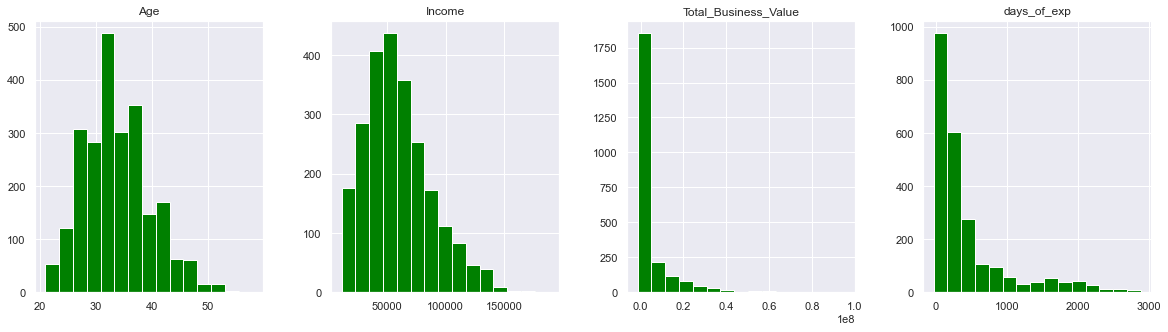

In [27]:
#Creating Histograms for Continuous Variables

df[continuous].hist(figsize=(20,5), bins=15, layout=(1,4), color ='green')
plt.show()

--------------------------------------------------------------------------------
Column Name : City


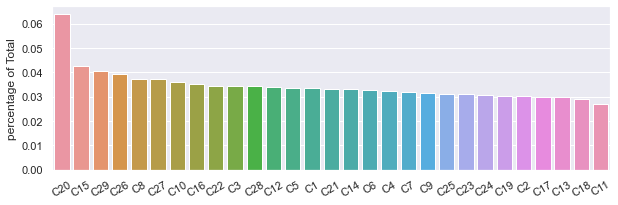

--------------------------------------------------------------------------------
Column Name : Education_Level


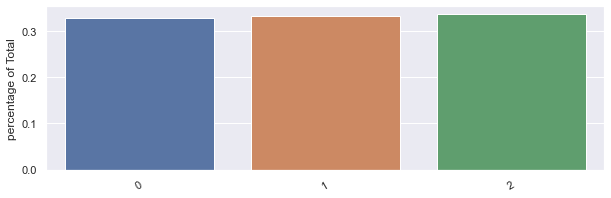

--------------------------------------------------------------------------------
Column Name : Gender


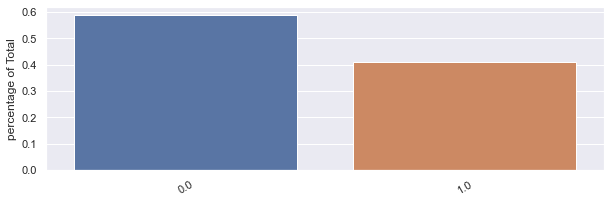

--------------------------------------------------------------------------------
Column Name : Grade


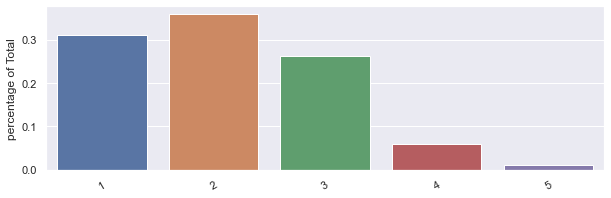

--------------------------------------------------------------------------------
Column Name : Joining_Designation


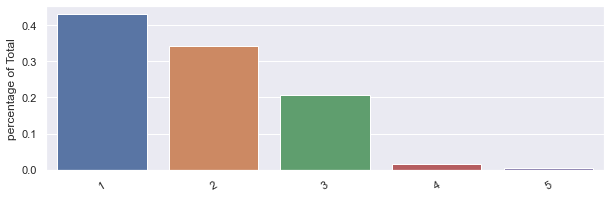

--------------------------------------------------------------------------------
Column Name : Quarterly_Rating


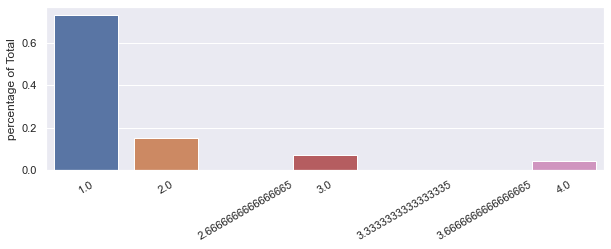

--------------------------------------------------------------------------------
Column Name : target


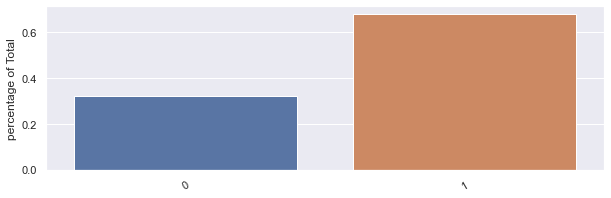

In [28]:
#Creating barplots for Categorical Variables
def barplot_columns(data, categorical):
    for col in categorical:
        print('-'*80)
        print(f'Column Name : {col}')
        plt.figure(figsize=(10,3))
        x = data[col].value_counts(normalize = True).index
        y = data[col].value_counts(normalize = True).values
        sns.barplot(x=x, y=y)
        plt.xticks(rotation=30)
        plt.ylabel('percentage of Total')
        plt.show()
        
barplot_columns(df, categorical)

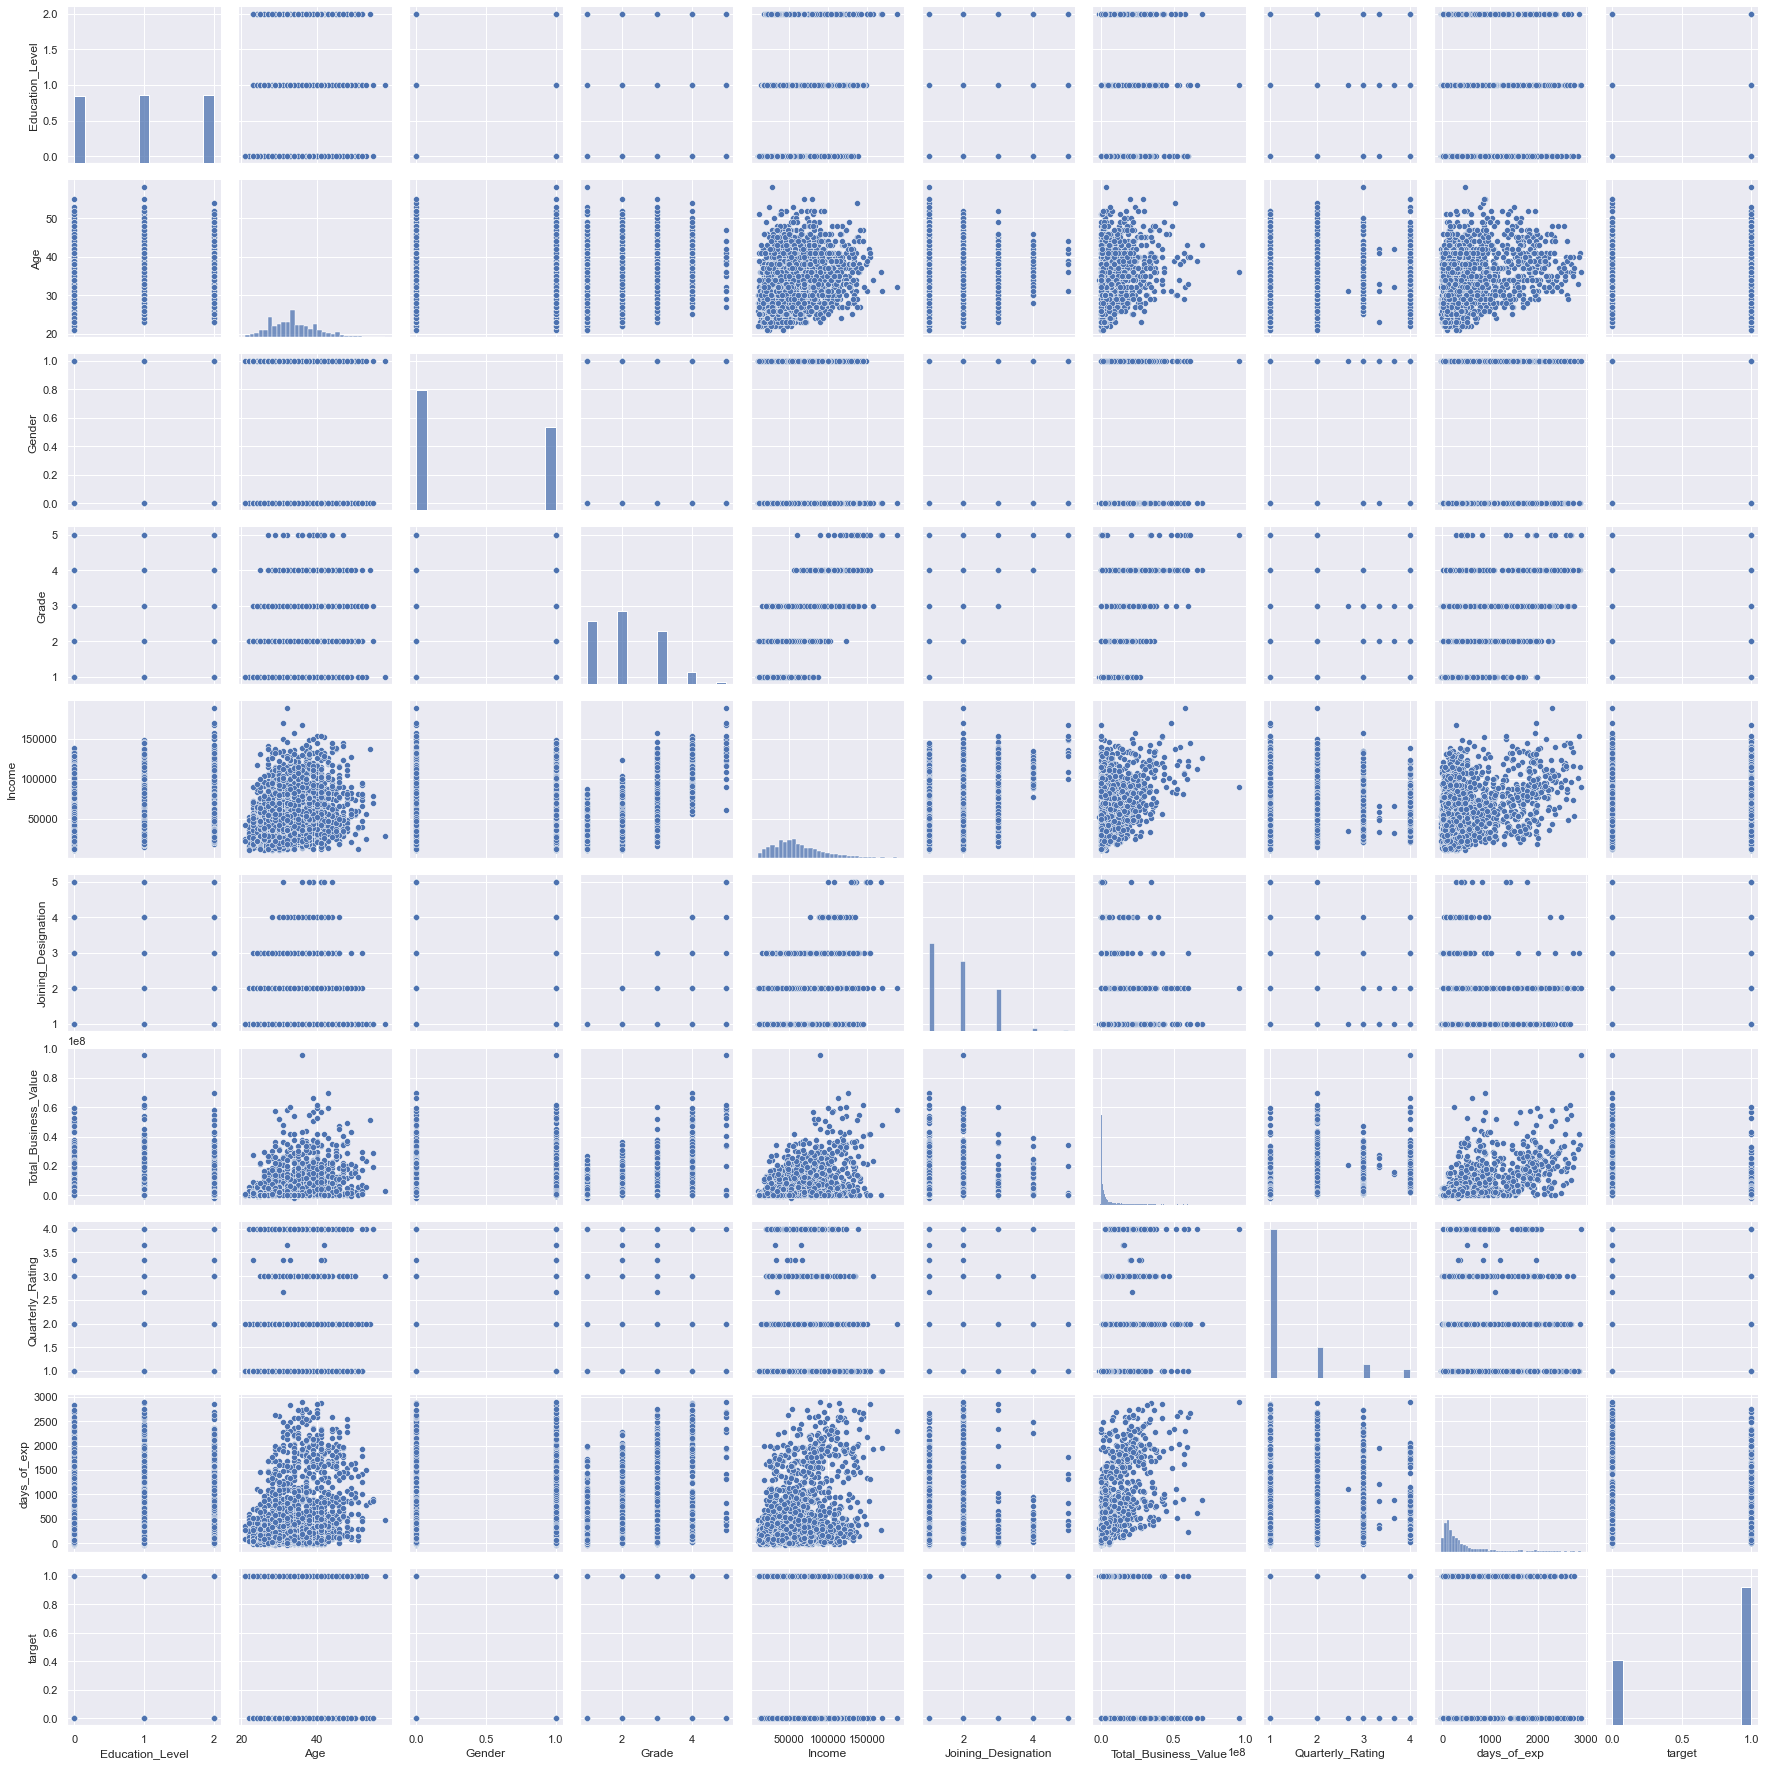

In [29]:
#Using PairPlot to plot scatter plots for all Numerical columns 
all_columns = df.columns
pairplot_columns = [item for item in all_columns if item not in ['Dateofjoining', 'LastWorkingDate', 'MMM_YY', 
                                                                'age_bin', 'income_bin', 'total_business_value_bin',
                                                                'previous_qtr_rating', 'decrease_qtr_rating']]
sns.pairplot(df[pairplot_columns])
plt.show()

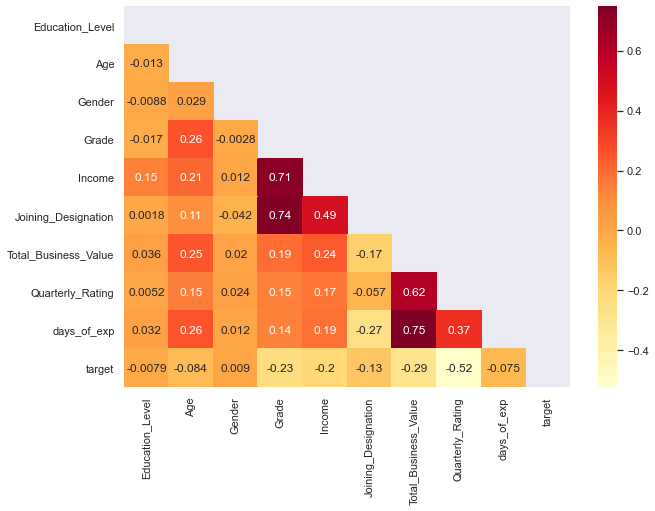

In [30]:
##Correlation Matrix
matrix_col = ['Education_Level', 'Age', 'Gender', 'Grade', 'Income', 'Joining_Designation', 'Total_Business_Value', 
              'Quarterly_Rating', 'days_of_exp','target']
corr = df[matrix_col].corr(method='spearman')
mask = np.triu(corr)
plt.figure(figsize=(10,7))
sns.heatmap(corr, annot = True, mask = mask, cmap = 'YlOrRd')
plt.show()

In [31]:
from sklearn.preprocessing import LabelEncoder

label_col = ['City', 'age_bin', 'income_bin','total_business_value_bin']

df2 = df.copy(deep = True)
df2.drop(['Age', 'Dateofjoining', 'Income', 'LastWorkingDate', 'MMM_YY', 'Total_Business_Value', 'days_of_exp'], 
          inplace = True, axis = 1)

In [32]:
df2

,City,Education_Level,Gender,Grade,Joining_Designation,Quarterly_Rating,previous_qtr_rating,decrease_qtr_rating,age_bin,income_bin,total_business_value_bin,target
Driver_ID,,,,,,,,,,,,
1,C23,2,0.0,1,1,2.0,2.0,0,"(25, 30]","(50000, 75000]","(10.0, 15.0]",1
2,C7,2,0.0,2,2,1.0,1.0,0,"(30, 35]","(50000, 75000]","(-0.1, 10.0]",0
4,C13,2,0.0,2,2,1.0,1.0,0,"(40, 45]","(50000, 75000]","(10.0, 15.0]",1
5,C9,0,0.0,1,1,1.0,1.0,0,"(25, 30]","(25000, 50000]","(10.0, 15.0]",1
6,C11,1,1.0,3,3,2.0,1.0,0,"(30, 35]","(75000, 100000]","(10.0, 15.0]",0
...,...,...,...,...,...,...,...,...,...,...,...,...
2784,C24,0,0.0,3,2,4.0,3.0,0,"(30, 35]","(75000, 100000]","(15.0, 20.0]",0
2785,C9,0,1.0,1,1,1.0,1.0,0,"(30, 35]","(0, 25000]","(-0.1, 10.0]",1
2786,C19,0,0.0,2,2,1.0,2.0,1,"(40, 45]","(25000, 50000]","(10.0, 15.0]",1


In [33]:
#le.fit(temp[label_col])
df2[label_col]= df2[label_col].apply(LabelEncoder().fit_transform)

In [34]:
def extended_info(raw_data):
    print('-'*80)
    print(f'Shape of Data : {raw_data.shape}')
    print('-'*80)
    summary_df = pd.DataFrame()
    summary_df['column_name'] = raw_data.columns
    summary_df['data_type'] = raw_data.dtypes.values
    summary_df['unique_Values'] = raw_data.nunique().values
    summary_df['percentage_missing_values'] = np.round(raw_data.isnull().sum().values / raw_data.shape[0], 4) *100
    summary_df.set_index('column_name', inplace = True)
    summary_df.sort_values(by=['percentage_missing_values'], ascending=False)
    print(summary_df)
    print('-'*80)
    return raw_data.head(10)

extended_info(df2)

--------------------------------------------------------------------------------
Shape of Data : (2381, 12)
--------------------------------------------------------------------------------
                         data_type  unique_Values  percentage_missing_values
column_name                                                                 
City                         int32             29                        0.0
Education_Level              int64              3                        0.0
Gender                     float64              2                        0.0
Grade                        int64              5                        0.0
Joining_Designation          int64              5                        0.0
Quarterly_Rating           float64              7                        0.0
previous_qtr_rating        float64              5                        0.0
decrease_qtr_rating          int64              2                        0.0
age_bin                      int32       

,City,Education_Level,Gender,Grade,Joining_Designation,Quarterly_Rating,previous_qtr_rating,decrease_qtr_rating,age_bin,income_bin,total_business_value_bin,target
Driver_ID,,,,,,,,,,,,
1,15,2,0.0,1,1,2.0,2.0,0,1,2,1,1
2,26,2,0.0,2,2,1.0,1.0,0,2,2,0,0
4,4,2,0.0,2,2,1.0,1.0,0,4,2,1,1
5,28,0,0.0,1,1,1.0,1.0,0,1,1,1,1
6,2,1,1.0,3,3,2.0,1.0,0,2,3,1,0
8,11,0,0.0,3,3,1.0,1.0,0,2,2,0,1
11,10,2,1.0,1,1,1.0,1.0,0,1,1,0,0
12,15,2,0.0,1,1,1.0,4.0,1,2,1,1,1
13,10,2,0.0,4,1,1.0,1.0,0,2,4,2,1


In [35]:
df.target.value_counts(normalize = True)

1    0.678706
0    0.321294
Name: target, dtype: float64

-----------------------------------------------

## Model Building

**Train-Test Split & SMOTE** 

In [36]:
from sklearn.model_selection import train_test_split, GridSearchCV

# Data preparation
x = df2.drop(columns = ['target'], axis = 1)
y = df2.target

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=23)

In [37]:
#Using SMOTE to balance the target variable
from imblearn.over_sampling import SMOTE
from collections import Counter

sm = SMOTE(random_state=23, k_neighbors=5)
x_train_sm, y_train_sm = sm.fit_resample(x_train, y_train)

In [38]:
print('Original dataset shape %s' % Counter(y_train))
print('Resampled dataset shape %s' % Counter(y_train_sm))

Original dataset shape Counter({1: 1075, 0: 520})
Resampled dataset shape Counter({1: 1075, 0: 1075})


### Model-01 Random Forest : Hyperparameter tuning using GridSearch_CV

In [39]:
#Random forest classifier with Pipeline & GridsearchCV

from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler

# Build a pipeline object
pipe_rf = Pipeline([
    ("minmax", MinMaxScaler()),
    ("rf", RandomForestClassifier())
])

pipe_rf

Pipeline(steps=[('minmax', MinMaxScaler()), ('rf', RandomForestClassifier())])

In [40]:
# Declare a hyperparameter grid
param_grid_rf = {
    "rf__criterion": ['gini', 'entropy'],
    "rf__n_estimators": [5,10,50,100,500,1000],
    "rf__max_depth": np.arange(2,20,5),
    "rf__max_features": np.arange(2,13)
}

# Perform grid search, fit it, and print score
gs_rf = GridSearchCV(pipe_rf, param_grid=param_grid_rf, cv=3, n_jobs=-1, verbose=1, scoring = 'roc_auc')
gs_rf

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('minmax', MinMaxScaler()),
                                       ('rf', RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'rf__criterion': ['gini', 'entropy'],
                         'rf__max_depth': array([ 2,  7, 12, 17]),
                         'rf__max_features': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
                         'rf__n_estimators': [5, 10, 50, 100, 500, 1000]},
             scoring='roc_auc', verbose=1)

In [41]:
gs_rf.fit(x_train_sm, y_train_sm)

Fitting 3 folds for each of 528 candidates, totalling 1584 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('minmax', MinMaxScaler()),
                                       ('rf', RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'rf__criterion': ['gini', 'entropy'],
                         'rf__max_depth': array([ 2,  7, 12, 17]),
                         'rf__max_features': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
                         'rf__n_estimators': [5, 10, 50, 100, 500, 1000]},
             scoring='roc_auc', verbose=1)

In [42]:
print(f'We can get roc_auc score of {np.round(gs_rf.best_score_, 4)} using {gs_rf.best_params_}')

We can get roc_auc score of 0.8918 using {'rf__criterion': 'entropy', 'rf__max_depth': 12, 'rf__max_features': 2, 'rf__n_estimators': 1000}


In [49]:
# model with the best hyperparameters
rfc = RandomForestClassifier(bootstrap=True,
                             criterion = 'entropy',
                             max_depth=12,
                             max_features=2,
                             n_estimators=1000)

In [50]:
# fit
rfc.fit(x_train_sm, y_train_sm)

RandomForestClassifier(criterion='entropy', max_depth=12, max_features=2,
                       n_estimators=1000)

In [54]:
# predict
y_pred_rf = rfc.predict(x_test)

**Classification report, Confusion Matrix & ROC_AUC Curve : Random Forest Model**

In [55]:
#ROC_AUC Curve
from sklearn import metrics
y_pred_rf_proba = rfc.predict_proba(x_test)
fpr, tpr, thr = metrics.roc_curve(y_test , y_pred_rf_proba[:,1])
auc_score = metrics.roc_auc_score( y_test, y_pred_rf_proba[:,1] )

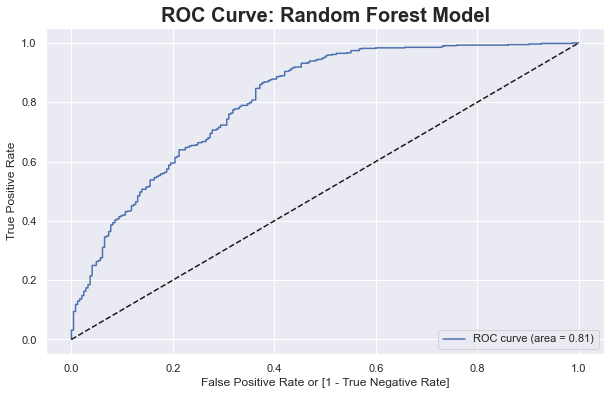

----------------------------------------------------------------------
ROC_AUC score =  	 0.80951
----------------------------------------------------------------------


In [56]:
plt.figure(figsize=(10,6))
plt.plot(fpr,tpr, label='ROC curve (area = %0.2f)' % auc_score )
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve: Random Forest Model',  fontsize = 20, fontweight = 'bold')
plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()
print('-'*70)
print(f'ROC_AUC score =  \t {np.round(auc_score,5)}')
print('-'*70)

In [57]:
#Important Metrics of Model
print('-'*70)
print('Important Metrics of Random Forest Model')
print('-'*70)
print(f'ROC_AUC score =  \t {np.round(auc_score,5)}')
print(f'Accuracy of Model : \t {np.round(metrics.accuracy_score(y_test,y_pred_rf),5)}')
print(f'f1_score of Model : \t {np.round(metrics.f1_score(y_test,y_pred_rf),5)}')
print(f'Precision of Model : \t {np.round(metrics.precision_score(y_test,y_pred_rf),5)}')
print(f'Recall of Model : \t {np.round(metrics.recall_score(y_test,y_pred_rf),5)}')
print('-'*70)

----------------------------------------------------------------------
Important Metrics of Random Forest Model
----------------------------------------------------------------------
ROC_AUC score =  	 0.80951
Accuracy of Model : 	 0.79008
f1_score of Model : 	 0.85095
Precision of Model : 	 0.83216
Recall of Model : 	 0.87061
----------------------------------------------------------------------


In [58]:
# Classification Report
from sklearn.metrics import classification_report,confusion_matrix
print('-'*70)
print('Classification Report: Random Forest')
print('-'*70)
print(classification_report(y_test,y_pred_rf))
print('-'*70)

----------------------------------------------------------------------
Classification Report: Random Forest
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.68      0.61      0.65       245
           1       0.83      0.87      0.85       541

    accuracy                           0.79       786
   macro avg       0.76      0.74      0.75       786
weighted avg       0.79      0.79      0.79       786

----------------------------------------------------------------------


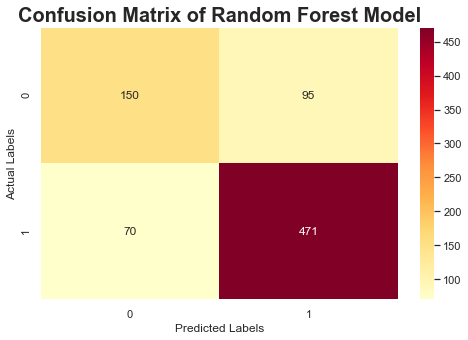

In [59]:
conf_matrix_rf = confusion_matrix(y_test,y_pred_rf)

plt.figure(figsize=(8,5))
sns.heatmap(conf_matrix_rf, annot = True, cmap = 'YlOrRd', fmt="1.0f")
plt.title('Confusion Matrix of Random Forest Model',fontsize = 20, fontweight = 'bold' )
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.show()

**Feature Importance in Random Forest Model**

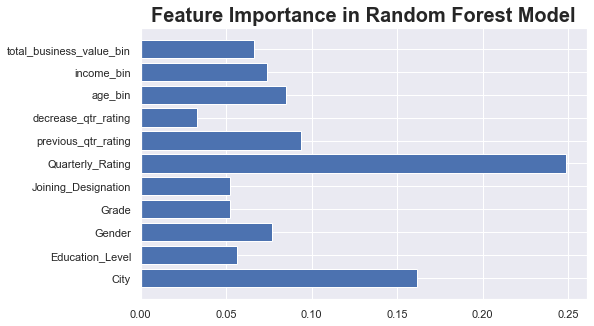

In [60]:
plt.figure(figsize=(8,5))
plt.barh(df2.columns[:-1], rfc.feature_importances_)
plt.title('Feature Importance in Random Forest Model',fontsize = 20, fontweight = 'bold' )
plt.show()

=> **Quarterly Rating has highest importance followed by City.**

### Model-02 LightGBM BOOSTING : Hyperparameter tuning using GridSearch_CV

In [ ]:
## !pip install lightgbm

In [61]:
import lightgbm as lgb
from lightgbm import LGBMClassifier

# Build a pipeline object

pipe_lgb = Pipeline([
    ("minmax", MinMaxScaler()),
    ("lgb", LGBMClassifier())
])

pipe_lgb


Pipeline(steps=[('minmax', MinMaxScaler()), ('lgb', LGBMClassifier())])

In [62]:
#creating parameter grid for LightGBM
param_grid_lgb = {
    'lgb__learning_rate': [0.005,0.01,0.05,0.1],
    'lgb__n_estimators': [40,60,80,100],
    'lgb__num_leaves': np.arange(10,20,2),
    'lgb__num_iterations': [ 100, 500, 1000, 2000]
    
    
}

# Perform grid search, fit it, and print score
gs_lgb = GridSearchCV(pipe_lgb, param_grid=param_grid_lgb, cv=3, n_jobs=-1, verbose=1, scoring = 'roc_auc')
gs_lgb

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('minmax', MinMaxScaler()),
                                       ('lgb', LGBMClassifier())]),
             n_jobs=-1,
             param_grid={'lgb__learning_rate': [0.005, 0.01, 0.05, 0.1],
                         'lgb__n_estimators': [40, 60, 80, 100],
                         'lgb__num_iterations': [100, 500, 1000, 2000],
                         'lgb__num_leaves': array([10, 12, 14, 16, 18])},
             scoring='roc_auc', verbose=1)

In [63]:
gs_lgb.fit(x_train_sm, y_train_sm)

Fitting 3 folds for each of 320 candidates, totalling 960 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('minmax', MinMaxScaler()),
                                       ('lgb', LGBMClassifier())]),
             n_jobs=-1,
             param_grid={'lgb__learning_rate': [0.005, 0.01, 0.05, 0.1],
                         'lgb__n_estimators': [40, 60, 80, 100],
                         'lgb__num_iterations': [100, 500, 1000, 2000],
                         'lgb__num_leaves': array([10, 12, 14, 16, 18])},
             scoring='roc_auc', verbose=1)

In [64]:
print(f'We can get roc_auc score of {np.round(gs_lgb.best_score_, 4)} using {gs_lgb.best_params_}')

We can get roc_auc score of 0.8883 using {'lgb__learning_rate': 0.1, 'lgb__n_estimators': 40, 'lgb__num_iterations': 100, 'lgb__num_leaves': 16}


In [65]:
# model with the best hyperparameters
lgb = lgb.LGBMClassifier(learning_rate = 0.1 ,n_estimators = 40, num_iterations=100 , num_leaves = 16)

In [66]:
# fit
lgb.fit(x_train_sm, y_train_sm)

LGBMClassifier(n_estimators=40, num_iterations=100, num_leaves=16)

In [67]:
# predict
y_pred_lgb = lgb.predict(x_test)

**Classification report, Confusion Matrix & ROC_AUC Curve : LightGBM Model**

In [68]:
#ROC_AUC Curve
from sklearn import metrics
y_pred_lgb_proba = lgb.predict_proba(x_test)
fpr, tpr, thr = metrics.roc_curve(y_test , y_pred_lgb_proba[:,1])
auc_score = metrics.roc_auc_score( y_test, y_pred_lgb_proba[:,1] )

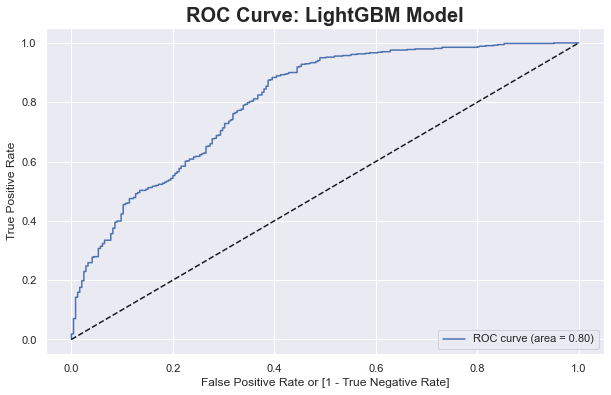

----------------------------------------------------------------------
ROC_AUC score =  	 0.80273
----------------------------------------------------------------------


In [69]:
plt.figure(figsize=(10,6))
plt.plot(fpr,tpr, label='ROC curve (area = %0.2f)' % auc_score )
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve: LightGBM Model',  fontsize = 20, fontweight = 'bold')
plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()
print('-'*70)
print(f'ROC_AUC score =  \t {np.round(auc_score,5)}')
print('-'*70)

In [70]:
#Important Metrics of Model
print('-'*70)
print('Important  Metrics of LightGBM Model')
print('-'*70)
print(f'ROC_AUC score =  \t {np.round(auc_score,5)}')
print(f'Accuracy of Model : \t {np.round(metrics.accuracy_score(y_test,y_pred_lgb),5)}')
print(f'f1_score of Model : \t {np.round(metrics.f1_score(y_test,y_pred_lgb),5)}')
print(f'Precision of Model : \t {np.round(metrics.precision_score(y_test,y_pred_lgb),5)}')
print(f'Recall of Model : \t {np.round(metrics.recall_score(y_test,y_pred_lgb),5)}')
print('-'*70)

----------------------------------------------------------------------
Important  Metrics of LightGBM Model
----------------------------------------------------------------------
ROC_AUC score =  	 0.80273
Accuracy of Model : 	 0.79262
f1_score of Model : 	 0.85329
Precision of Model : 	 0.83158
Recall of Model : 	 0.87616
----------------------------------------------------------------------


In [71]:
# Classification Report
from sklearn.metrics import classification_report,confusion_matrix
print('-'*70)
print('Classification Report: LightGBM Model')
print('-'*70)
print(classification_report(y_test,y_pred_lgb))
print('-'*70)

----------------------------------------------------------------------
Classification Report: LightGBM Model
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.69      0.61      0.65       245
           1       0.83      0.88      0.85       541

    accuracy                           0.79       786
   macro avg       0.76      0.74      0.75       786
weighted avg       0.79      0.79      0.79       786

----------------------------------------------------------------------


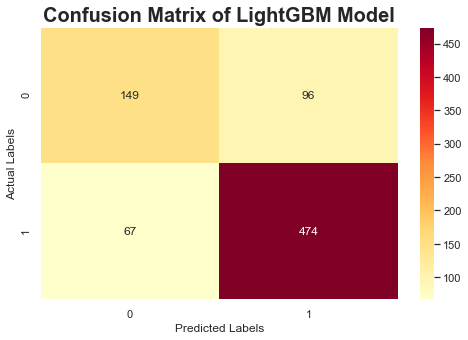

In [72]:
conf_matrix_rf = confusion_matrix(y_test,y_pred_lgb)

plt.figure(figsize=(8,5))
sns.heatmap(conf_matrix_rf, annot = True, cmap = 'YlOrRd', fmt="1.0f")
plt.title('Confusion Matrix of LightGBM Model',fontsize = 20, fontweight = 'bold' )
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.show()

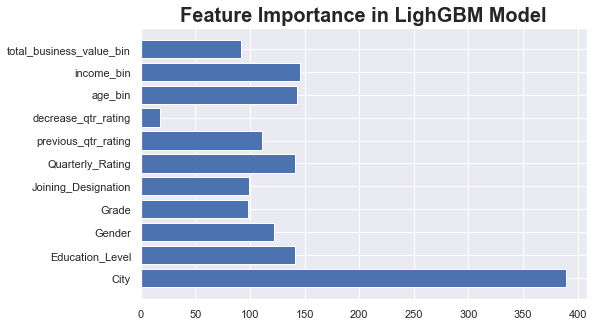

In [73]:
plt.figure(figsize=(8,5))
plt.barh(df2.columns[:-1], lgb.feature_importances_)
plt.title('Feature Importance in LighGBM Model',fontsize = 20, fontweight = 'bold' )
plt.show()

Feature Importance: 

=> **City has highest importance in LightGBM model.**

----------------------------------------------------------------------------------

## Actionable insights and recommendations

=> **Data insights**


- **Count of Drivers**: 2381 unique driver_id data
- **Date range - 2 years (i.e. 728 days)**
- Data Duration (Time Frame)

--------------------------------------------------------------------------------
Range of MMM_YY

Min : 2019-01-01 00:00:00 	 Max : 2020-12-01 00:00:00

700 days 00:00:00

--------------------------------------------------------------------------------
Range of LastWorkingDate

Min : 2018-12-31 00:00:00 	 Max : 2020-12-28 00:00:00

728 days 00:00:00

--------------------------------------------------------------------------------
Range of Dateofjoining

Min : 2013-01-04 00:00:00 	 Max : 2020-12-28 00:00:00

2915 days 00:00:00

--------------------------------------------------------------------------------



- **City** : 29 Unique cities are covered.
- **Education Level**: Education level of drivers is uniformly distributed. All three categories have almost equal number of drivers.
- **Age** : Age of drivers almost follow normal distribution with range of (21 years to 58 years) and mean at 33 years.
- **Gender**: Ratio of Count of Male (0) to count of female (1) is 60% : 40% 
- **Grade**: 5 unique Grades, Grade 2 has highest & Grade 5 has lowest number of drivers
- **Income**: Monthly Income follows log normal distribution. Range is (0 to 150000)
- **Total Business Value**: Lot of Drivers have 0 Total Business values.
- **Quarterly Ratings**: 4 categories of Ratings present. Maximum drivers have rating = 1
- **Days of Experience**: Follows log-normal distribution. As value of experience increases, the count keep on decreasing.
- **Joining Designation**: 5 unique categories present. JD-1 has highest count & JD-5 has lowest count.
- **Target Variable**: 0: not churned, 1 : churned. Ratio is around 30% : 70% 



- **Significant Correlation was found between Income & Grade**, indicating drivers with higher grades have higher monthly income.
- **Significant correlation was found between Total Business value and days of experience**. This indicates that drivers with highers days of experience create more business value.
- **Significant corelation was found between Joining Designation and Grade.** This indicates as the Grade of Driver increases, joining designation also increases.
- **Quarterly Ratings also have significant corelation with Total Business value.** This indicate if drivers improve on their ratings, their business value also keeps on increasing.



**Model-01 Random Forest : Hyperparameter tuning using GridSearch_CV**
----------------------------------------------------

Model was created using Bagging Technique : Random Forest. Hyperparameter tunning was done using GridSearchCV. Best model was selected based on highest ROC_AUC score.

**----------------------------------------------------------------------**

**Important Metrics of Random Forest Model**

**----------------------------------------------------------------------**

**ROC_AUC score =  	 0.80273**

**Accuracy of Model : 	 0.78626**

**f1_score of Model : 	 0.84865**

**Precision of Model : 	 0.82777**

**Recall of Model : 	 0.87061**

----------------------------------------------------------------------

Feature Importance of Random Forest: 
=> **Quarterly Rating has highest importance followed by City.**


**Model-02 LightGBM BOOSTING : Hyperparameter tuning using GridSearch_CV**
------------------------

Model was created using Boosting Technique : LightGBM. Hyperparameter tunning was done using GridSearchCV. Best model was selected based on highest ROC_AUC score.


**----------------------------------------------------------------------**

**Important  Metrics of LightGBM Model**

**----------------------------------------------------------------------**

**ROC_AUC score =  	 0.80273**

**Accuracy of Model : 	 0.79262**

**f1_score of Model : 	 0.85329**

**Precision of Model : 	 0.83158**

**Recall of Model : 	 0.87616**

----------------------------------------------------------------------

Feature Importance of Random Forest: 
=> **City has highest importance in LightGBM model.**



**Action points for Business based on Analysis:**

- Churn rate of Drivers is very high (i.e. around 70%). This is not a healthy situation for business.
- Based on both model created, it was concluded that City & Quarterly Rating has significant impact on Churning of Drivers.
- Company should take extra care of Cities where Churn rate is high.
- Company should take extra efforts in terms of training of compensation to improve the Quarterly Rating of Drivers.




### ------------------------------ End ------------------------------